In [0]:
import scipy.io.wavfile as wav
import librosa as lr
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch import optim
import torch.nn as nn
import torchvision.models as models
import torch

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_path='/content/drive/My Drive/'
os.listdir('/content/drive/My Drive/')

['Getting started.pdf',
 'Colab Notebooks',
 'br_mini',
 'dv_mini',
 'mn_mini',
 'tr_mini',
 'ML_data',
 'finalized',
 'test_set']

In [0]:
torch.cuda.is_available()

True

In [0]:
tr_mini=[data_path+'tr_mini/'+i for i in os.listdir(data_path+'tr_mini')]
br_mini=[data_path+'br_mini/'+i for i in os.listdir(data_path+'br_mini')]
mn_mini=[data_path+'mn_mini/'+i for i in os.listdir(data_path+'mn_mini')]
dv_mini=[data_path+'dv_mini/'+i for i in os.listdir(data_path+'dv_mini')]

In [0]:
data=pd.DataFrame({'fname':tr_mini,'label': [1 for i in range(len(tr_mini))]})
data=pd.concat([data,pd.DataFrame({'fname':br_mini,'label': [4 for i in range(len(br_mini))]})])
data=pd.concat([data,pd.DataFrame({'fname':dv_mini,'label': [3 for i in range(len(dv_mini))]})])
data=pd.concat([data,pd.DataFrame({'fname':mn_mini,'label': [2 for i in range(len(mn_mini))]})])

In [0]:
df = data.sample(frac=1).reset_index(drop=True)

In [0]:
class Config(object):
  
  def __init__(self,
                 lr,epochs,sample_freq=44000, audio_length=5, n_classes=4,n_mfcc=20):
    self.sample_freq=sample_freq
    self.n_classes=4
    self.n_mfcc=n_mfcc
    self.audio_length=audio_length;
    self.max_len=audio_length*sample_freq
    self.epochs=epochs
    self.lr=lr
    self.dim = (self.n_mfcc, 1 + int(np.floor(self.max_len/512)), 1)

config=Config(lr=0.0001,epochs=20) 

In [0]:
def prepare_data(df,config):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.max_len
    for i, fname in enumerate(df.fname):
        file_path =fname
        data, _ = lr.core.load(file_path, sr=config.sample_freq, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = lr.feature.mfcc(data,sr=config.sample_freq, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [0]:
X_train=prepare_data(df,config)

In [0]:
X_train.shape

(5541, 20, 430, 1)

In [0]:
X_train=X_train.squeeze()
x=X_train.reshape(X_train.shape[0],-1)
x=torch.tensor(x)
x=x.float()
x_train=x[:4000]
x_val=x[4000:]

In [0]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_val=(x_val-mean)/std
mean,std

(tensor(-19.2376), tensor(114.0728))

In [0]:
Y_train=np.asarray(df.label)
y=torch.tensor(Y_train)
y=y-1
y_train=y[:4000]
y_val=y[4000:]


In [0]:
def kaim_uniform(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal(m.weight.data)

In [0]:
def kaim_normal(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal(m.weight.data)

In [0]:
def get_model(lr):
  model=nn.Sequential(nn.Linear(8600,4300),
                      nn.BatchNorm1d(4300),
                      nn.ReLU(),
                      nn.Linear(4300,2150),
                      nn.BatchNorm1d(2150),
                      nn.ReLU(),
                      nn.Linear(2150,1075),
                      nn.BatchNorm1d(1075),
                      nn.ReLU(),
                      nn.Linear(1075,500),
                      nn.BatchNorm1d(500),
                      nn.ReLU(),
                      nn.Linear(500,200),
                      nn.BatchNorm1d(200),
                      nn.ReLU(),
                      nn.Linear(200,100),
                      nn.BatchNorm1d(100),
                      nn.ReLU(),
                      nn.Linear(100,50),
                      nn.BatchNorm1d(50),
                      nn.ReLU(),
                      nn.Linear(50,4))
  model.apply(kaim_uniform)
                       
  return model,optim.SGD(model.parameters(),lr=lr,momentum=0.9)

In [60]:
model,opt=get_model(0.0003)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
model=model.to('cuda')


In [0]:
def accuracy(out,yb): return (torch.argmax(out,dim=1)==yb).float().mean()
loss_func=F.cross_entropy

In [63]:
n=len(y_train)
bs=64
x_tmp=x_train[:64].float()
pred=model(x_tmp.to('cuda'))
pred.shape,pred[0]

(torch.Size([64, 4]),
 tensor([-0.4207, -0.0739, -0.4796,  0.9332], device='cuda:0',
        grad_fn=<SelectBackward>))

In [0]:
y_val=y_val.to('cuda')

In [0]:
def get_batches(y_trian,bs):
  for n in range(0,len(y_train),bs):
    yield x_train[n:n+bs].to('cuda'),y_train[n:n+bs].to('cuda')

In [66]:
mm=get_batches(y_train,64)
next(mm)

(tensor([[-5.6616, -5.6616, -5.6616,  ...,  0.1686,  0.1686,  0.1686],
         [-4.6970, -4.6970, -4.6970,  ...,  0.1686,  0.1686,  0.1686],
         [-4.3561, -4.3561, -4.3561,  ...,  0.1686,  0.1686,  0.1686],
         ...,
         [-1.5522, -1.8062, -1.9218,  ..., -0.0667,  0.0192,  0.0506],
         [-4.7472, -4.7472, -4.7472,  ...,  0.1686,  0.1686,  0.1686],
         [-4.5841, -4.5841, -4.5841,  ...,  0.1686,  0.1686,  0.1686]],
        device='cuda:0'),
 tensor([0, 1, 1, 1, 3, 1, 3, 3, 0, 2, 3, 0, 3, 0, 3, 3, 1, 1, 0, 0, 3, 1, 3, 1,
         0, 3, 0, 3, 1, 3, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 0, 1, 3, 1, 3, 2, 3, 1,
         2, 3, 2, 0, 2, 2, 3, 0, 1, 2, 3, 0, 1, 1, 3, 3], device='cuda:0'))

In [0]:
bs=64
def train_loop(epoch,lr):
  train_loss=[]
  val_loss=[]
  acc=[]
  opt=optim.Adam(model.parameters(),lr)
#   val_loss=2
  for epoch in range(epoch):
    lol=0;
    batch=get_batches(y_train,bs)
    for xb,yb in batch:
        pred = model(xb)
        loss = loss_func(pred, yb)
#         print(loss)
        lol+=loss
        loss.backward()
        opt.step()
        opt.zero_grad()
#         for p in model.parameters():
#           p.register_hook(lambda grad: torch.clamp(grad, -1, 1))
    ans=model(x_val.to('cuda'))
    val_tmp=loss_func(ans,y_val)
#     if val_loss>val_tmp:
#       val_loss=val_tmp
#       torch.save('stop')
    val_loss.append(val_tmp)
    print("validation-{}".format(val_loss[epoch]))
    
    acc.append(accuracy(ans,y_val))
    print("accuracy-{}".format(acc[-1]))
    train_loss.append(lol/((n-1)//64 + 1))
    print("train_loss-{}".format(train_loss[-1]))
  plt.plot(val_loss,label='val_loss')
  plt.plot(train_loss,label='train_loss')
  plt.plot(acc,label='acc')
  plt.legend()

validation-0.670589029788971
accuracy-0.7962362170219421
train_loss-0.2846868634223938
validation-0.620619535446167
accuracy-0.8163530230522156
train_loss-0.24638958275318146
validation-0.6199025511741638
accuracy-0.8189487457275391
train_loss-0.1962801218032837


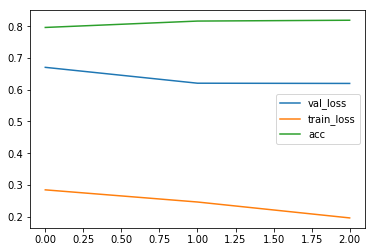

In [70]:
train_loop(3,0.001)

validation-0.5669784545898438
accuracy-0.8345230221748352
train_loss-0.10000381618738174
validation-0.5818291902542114
accuracy-0.8345230221748352
train_loss-0.06687801331281662
validation-0.588683009147644
accuracy-0.8397144675254822
train_loss-0.05300580710172653


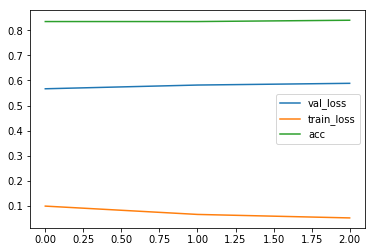

In [71]:
train_loop(3,0.0001)

validation-0.5843309164047241
accuracy-0.841661274433136
train_loss-0.04443538188934326
validation-0.5860282182693481
accuracy-0.8403633832931519
train_loss-0.04238271713256836
validation-0.5869075655937195
accuracy-0.8403633832931519
train_loss-0.04101283475756645


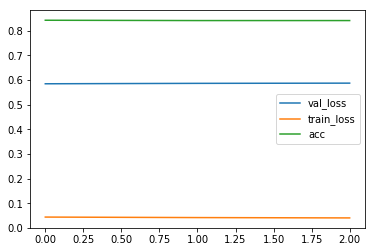

In [73]:
train_loop(3,0.00001)

In [0]:
loss_func(model(x_val.to('cuda')),y_val),accuracy(model(x_val.to('cuda')),y_val)

(tensor(0.4975, device='cuda:0', grad_fn=<NllLossBackward>),
 tensor(0.8326, device='cuda:0'))

In [0]:
torch.save(model,'best_1')